# 0.Getting setup

In [10]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 30.94 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [11]:
# device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 1.Getting data

In [12]:
from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves
from torchinfo import summary
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms



In [13]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")
data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [14]:
# creating train , test
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

# 2.FoodVision Mini model deployement experiment outline

# 3.Creating an EffNetB2 feature extractor

In [15]:
effnet_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnet_transform = effnet_weights.transforms()
effnetb2 = torchvision.models.efficientnet_b2(weights=effnet_weights)
for param in effnetb2.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 81.9MB/s]


In [16]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [17]:
effnetb2.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
  nn.Linear(in_features=1408, out_features=3, bias=True)
)

## 3.1 Creating a function to make an effnetb2 feature extractor

In [18]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [19]:
effnetb2 , effnet_transform = create_effnetb2_model()

In [20]:
from torchinfo import summary
summary(model=effnetb2,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 3.2 Creating DataLoaders for EffNetB2

In [21]:
from going_modular.going_modular import data_setup
train_effnet_dataloader , test_effnet_dataloader , num_classes = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                               test_dir=test_dir,
                                                                                               transform=effnet_transform,
                                                                                               batch_size=32)
train_effnet_dataloader , num_classes

(<torch.utils.data.dataloader.DataLoader at 0x7c182c437310>,
 ['pizza', 'steak', 'sushi'])

## 3.3 Training EffNetB2 Feature extractor

In [22]:
from going_modular.going_modular import engine
optimizer = torch.optim.Adam(params=effnetb2.parameters() , lr=0.01)
loss_fn = nn.CrossEntropyLoss()
set_seeds(42)
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_effnet_dataloader,
                                test_dataloader=test_effnet_dataloader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=5,
                                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.5844 | train_acc: 0.7229 | test_loss: 0.2182 | test_acc: 0.9386
Epoch: 2 | train_loss: 0.2412 | train_acc: 0.9250 | test_loss: 0.1707 | test_acc: 0.9443
Epoch: 3 | train_loss: 0.2719 | train_acc: 0.9083 | test_loss: 0.1931 | test_acc: 0.9381
Epoch: 4 | train_loss: 0.2386 | train_acc: 0.9292 | test_loss: 0.1827 | test_acc: 0.9347
Epoch: 5 | train_loss: 0.1938 | train_acc: 0.9146 | test_loss: 0.1568 | test_acc: 0.9472


## 3.4 Inspecting loss curves

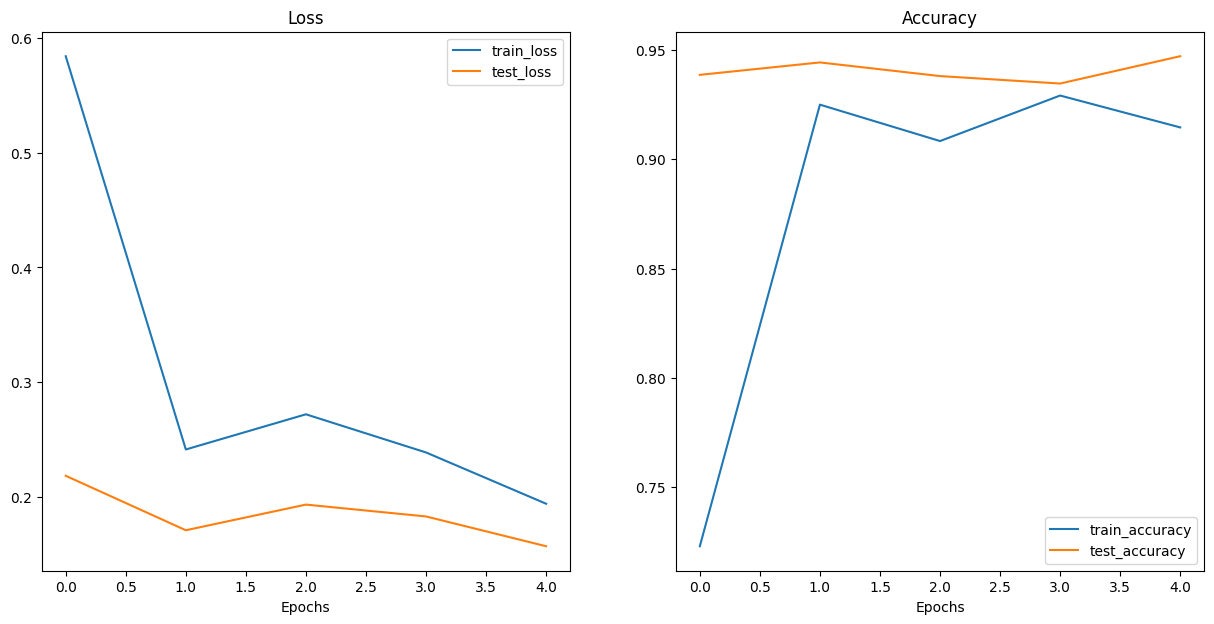

In [23]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_results)

## 3.5 Saving effnetb2 model


In [24]:
from going_modular.going_modular import utils
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="effnetb2.pth")

[INFO] Saving model to: models/effnetb2.pth


## 3.6 Checking effnetb2 size

In [25]:
from pathlib import Path
effnetb2_size = Path("models/effnetb2.pth").stat().st_size // (1024**2)
effnetb2_size

29

## 3.7 Collecting EffNetb2 feature extractor stats

In [26]:
# count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [27]:
# putting everything in a dict
effnetb2_dict = {
    "test loss" : effnetb2_results['test_loss'][-1],
    "test acc" : effnetb2_results['test_acc'][-1],
    "number of params" : effnetb2_total_params,
    "model size (MB)":effnetb2_size
}
effnetb2_dict

{'test loss': 0.1567613050341606,
 'test acc': 0.947159090909091,
 'number of params': 7705221,
 'model size (MB)': 29}

# 4 Creating a ViT feature extractor

In [28]:
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
transforms = weights.transforms()
model = torchvision.models.vit_b_16(weights=weights)
model

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 98.4MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [29]:
def create_ViT_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.heads = nn.Sequential(
        nn.Linear(in_features=768, out_features=3, bias=True)
    )

    return model, transforms

In [30]:
vit , vit_transform = create_ViT_model()

In [31]:
from torchinfo import summary
summary(model=vit,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [32]:
from going_modular.going_modular import data_setup
train_vit_dataloader , test_vit_dataloader , num_classes = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                               test_dir=test_dir,
                                                                                               transform=vit_transform,
                                                                                               batch_size=32)
train_vit_dataloader , num_classes

(<torch.utils.data.dataloader.DataLoader at 0x7c182c4cc5b0>,
 ['pizza', 'steak', 'sushi'])

In [33]:
from going_modular.going_modular import engine
optimizer = torch.optim.Adam(params=vit.parameters() , lr=0.01)
loss_fn = nn.CrossEntropyLoss()
set_seeds(42)
vit_results = engine.train(model=vit,
                                train_dataloader=train_vit_dataloader,
                                test_dataloader=test_vit_dataloader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=5,
                                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5639 | train_acc: 0.8625 | test_loss: 0.0763 | test_acc: 0.9784
Epoch: 2 | train_loss: 0.1247 | train_acc: 0.9500 | test_loss: 0.0534 | test_acc: 0.9693
Epoch: 3 | train_loss: 0.0690 | train_acc: 0.9521 | test_loss: 0.0470 | test_acc: 0.9812
Epoch: 4 | train_loss: 0.0236 | train_acc: 0.9896 | test_loss: 0.1171 | test_acc: 0.9443
Epoch: 5 | train_loss: 0.0129 | train_acc: 0.9938 | test_loss: 0.0861 | test_acc: 0.9568


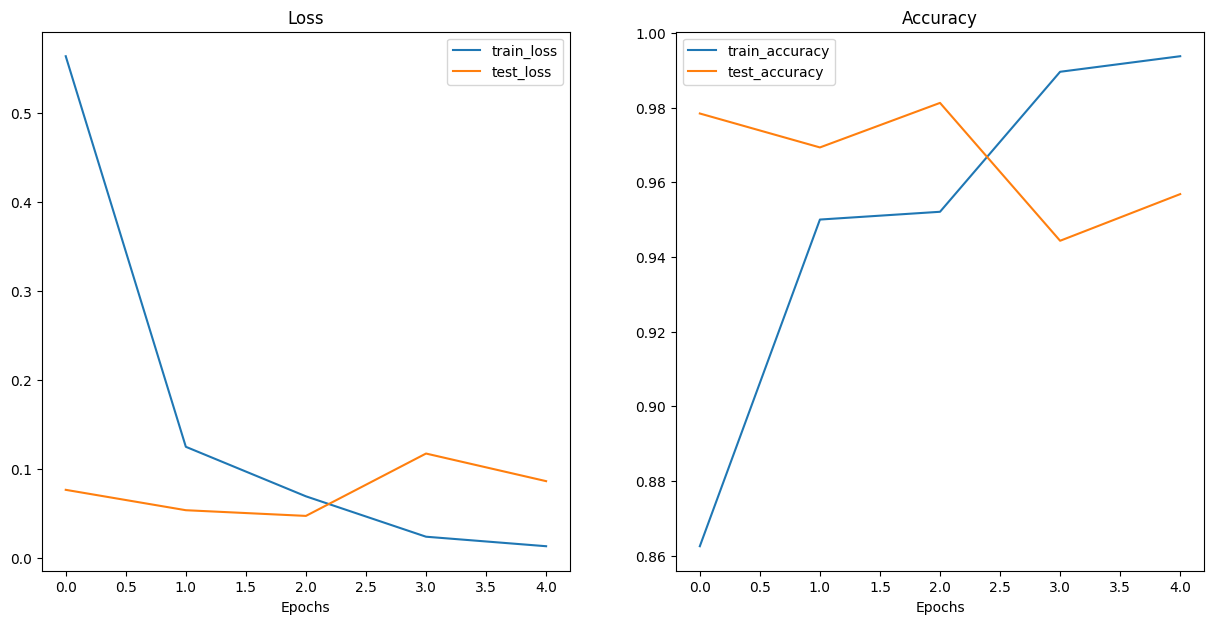

In [34]:
from helper_functions import plot_loss_curves
plot_loss_curves(vit_results)

In [35]:
from going_modular.going_modular import utils
utils.save_model(model=vit,
                 target_dir="models",
                 model_name="vit.pth")

[INFO] Saving model to: models/vit.pth


In [36]:
from pathlib import Path
vit_size = Path("models/vit.pth").stat().st_size // (1024**2)
vit_size

327

In [37]:
# count number of parameters in vit
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [38]:
# putting everything in a dict
vit_dict = {
    "test loss" : vit_results['test_loss'][-1],
    "test acc" : vit_results['test_acc'][-1],
    "number of params" : vit_total_params,
    "model size (MB)":vit_size
}
vit_dict

{'test loss': 0.08605407848953561,
 'test acc': 0.9568181818181818,
 'number of params': 85800963,
 'model size (MB)': 327}

# 5.Making predictions with  our trained models and timing them

In [39]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory ;{test_dir}" )
test_data_path = list(Path(test_dir).glob('*/*.jpg'))
test_data_path[:2]

[INFO] Finding all filepaths ending with '.jpg' in directory ;data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3479599.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2716791.jpg')]

## 5.1 Creating a function to make predictions across the test dataset

In [65]:
%%writefile going_modular/going_modular/predictions.py
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaires
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

Overwriting going_modular/going_modular/predictions.py


## 5.2 Making and Timing predictions with EffNetB2

In [68]:
from going_modular.going_modular import predictions
from pathlib import Path
effnetb2_test_pred_dict = pred_and_store(model=effnetb2,
                                         paths=test_data_path,
                                         class_names=num_classes,
                                         transform=effnet_transform)


  0%|          | 0/150 [00:00<?, ?it/s]

In [43]:
effnetb2_test_pred_dict[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3479599.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9521,
  'pred_class': 'steak',
  'time_for_pred': 0.3333,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2716791.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9046,
  'pred_class': 'steak',
  'time_for_pred': 0.2761,
  'correct': True}]

In [44]:
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dict)
effnetb2_test_pred_df.head(5)

image_path class_name  pred_prob  \
0  data/pizza_steak_sushi_20_percent/test/steak/3...      steak     0.9521   
1  data/pizza_steak_sushi_20_percent/test/steak/2...      steak     0.9046   
2  data/pizza_steak_sushi_20_percent/test/steak/8...      steak     0.9985   
3  data/pizza_steak_sushi_20_percent/test/steak/4...      steak     0.9530   
4  data/pizza_steak_sushi_20_percent/test/steak/2...      steak     0.9991   

  pred_class  time_for_pred  correct  
0      steak         0.3333     True  
1      steak         0.2761     True  
2      steak         0.1574     True  
3      steak         0.1513     True  
4      steak         0.1455     True

In [45]:
# Check number of coorect predicitions
effnetb2_test_pred_df["correct"].value_counts()

correct
True     142
False      8
Name: count, dtype: int64

In [46]:
# find the average time per prediction
effnet_avg_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(),4)
print(f"EffNetB2 average time per prediction: {effnet_avg_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.1759 seconds


In [47]:
# Add Effnetb2 average predictions time to stats dictionary
effnetb2_dict['time_per_pred_cpu'] = effnet_avg_time_per_pred
effnetb2_dict

{'test loss': 0.1567613050341606,
 'test acc': 0.947159090909091,
 'number of params': 7705221,
 'model size (MB)': 29,
 'time_per_pred_cpu': 0.1759}

## 5.3 Making and timing predictions with ViT

In [50]:
#from going_modular.going_modular.predictions import pred_and_store
from pathlib import Path
vit_test_pred_dict = pred_and_store(model=vit,
                                         paths=test_data_path,
                                         class_names=num_classes,
                                         transform=vit_transform)

  0%|          | 0/150 [00:00<?, ?it/s]

In [51]:
vit_test_pred_dict[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3479599.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9886,
  'pred_class': 'steak',
  'time_for_pred': 0.8528,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2716791.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9999,
  'pred_class': 'steak',
  'time_for_pred': 1.0089,
  'correct': True}]

In [52]:
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dict)
vit_test_pred_df.head(5)

image_path class_name  pred_prob  \
0  data/pizza_steak_sushi_20_percent/test/steak/3...      steak     0.9886   
1  data/pizza_steak_sushi_20_percent/test/steak/2...      steak     0.9999   
2  data/pizza_steak_sushi_20_percent/test/steak/8...      steak     1.0000   
3  data/pizza_steak_sushi_20_percent/test/steak/4...      steak     0.9999   
4  data/pizza_steak_sushi_20_percent/test/steak/2...      steak     0.9994   

  pred_class  time_for_pred  correct  
0      steak         0.8528     True  
1      steak         1.0089     True  
2      steak         1.2402     True  
3      steak         1.2346     True  
4      steak         1.0447     True

In [53]:
# Check number of coorect predicitions
vit_test_pred_df['correct'].value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [54]:
# find the average time per prediction
vit_avg_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(),4)
print(f"EffNetB2 average time per prediction: {vit_avg_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.9323 seconds


In [55]:
# Add Effnetb2 average predictions time to stats dictionary
vit_dict['time_per_pred_cpu'] = vit_avg_time_per_pred
vit_dict

{'test loss': 0.08605407848953561,
 'test acc': 0.9568181818181818,
 'number of params': 85800963,
 'model size (MB)': 327,
 'time_per_pred_cpu': 0.9323}

# 6. Comparing model results , prediction time and size

In [56]:
# Turn stat dict into dataframe
df=pd.DataFrame([effnetb2_dict , vit_dict])

# add column for model names
df['models'] = ['effnetb2','ViT_16']

# Convert accuracy to percentages
df['test_acc'] = round(df["test acc"]*100 ,2)
df

test loss  test acc  number of params  model size (MB)  time_per_pred_cpu  \
0   0.156761  0.947159           7705221               29             0.1759   
1   0.086054  0.956818          85800963              327             0.9323   

     models  test_acc  
0  effnetb2     94.72  
1    ViT_16     95.68

In [57]:
# compare ViT vs EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index('models').loc["ViT_16"] / df.set_index('models').loc['effnetb2'] ),
columns= ['ViT to EffNetb2 ratio'] ).T

test loss  test acc  number of params  model size (MB)  \
ViT to EffNetb2 ratio    0.54895  1.010198         11.135432        11.275862   

                       time_per_pred_cpu  test_acc  
ViT to EffNetb2 ratio           5.300171  1.010135

## 6.1 Visulize speed vs performance tradeoff

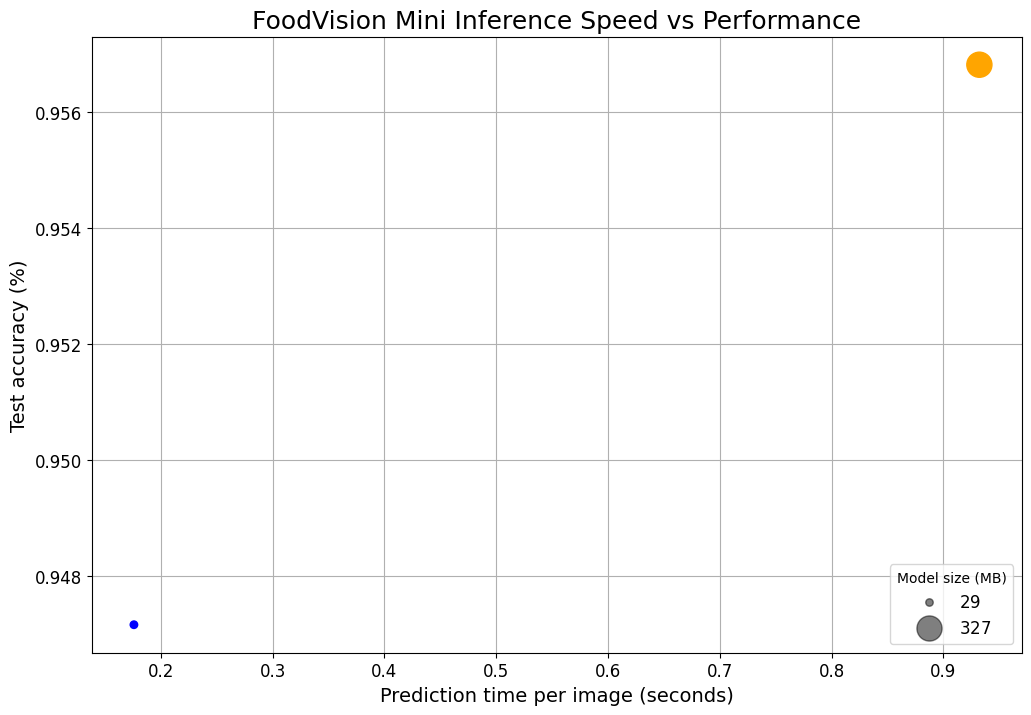

In [58]:
# 1. Create a plot from model comparison DataFrame
import os
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test acc",
                     c=["blue", "orange"], # what colours to use?
                     s="model size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["models"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
!mkdir images/

plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

# 7. Bringing FoodVision Mini to life by Createing a gradio Demo

In [59]:
# installing and impoering gradio
try:
  import gradio as gr
except:
  !pip -q install gradio
  import gradio as gr
gr.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.8/857.8 kB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 6.4 MB

'4.38.1'

In [60]:
vit.to("cpu")
#check the device
next(iter(vit.parameters())).device

device(type='cpu')

In [61]:
# Creating a function that replicate the previous workoflow of prediction
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = vit_transform(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(vit(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {num_classes[i]: float(pred_probs[0][i]) for i in range(len(num_classes))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

################################################################################
from timeit import default_timer as timer
# try prediciton
import random
from PIL import Image
# Get a list of all test image file paths
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))

# randomly select an image
random_image_path = random.sample(test_data_paths, 1)[0]

# open image target
image = Image.open(random_image_path)
print(f"[INFO] Predict on image at path : {random_image_path} \n")

# predict on the target image and print out the outputs
pred_dict,pred_time = predict(img=image)
print(f"[INFO] Prediction label and probability dictionary : \n {pred_dict}")
print(f"[INFO] Prediction time : {pred_time} s ")

[INFO] Predict on image at path : data/pizza_steak_sushi_20_percent/test/sushi/389730.jpg 

[INFO] Prediction label and probability dictionary : 
 {'pizza': 0.00011764598457375541, 'steak': 4.380743575893575e-06, 'sushi': 0.9998779296875}
[INFO] Prediction time : 0.97051 s 


# 7.3 Creating a list of exemple images

In [62]:
exemple_list=[[str(filepath)] for filepath in random.sample(test_data_paths , k=3)]
exemple_list

[['data/pizza_steak_sushi_20_percent/test/sushi/1203702.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/2111981.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/3173402.jpg']]

# 7.4 Building a Gradio interface

In [63]:
import gradio as gr
title="FoodVision"
description="EffNetB2 feature extractor computer vision model"
article="Created"

# Create gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are inputs
                    outputs=[gr.Label(num_top_classes = len(num_classes) , label="Prediction"),  # what are the output
                    gr.Number(label="Prediction time (s)")], # our fn has two outputs , therefore we have two outputs
                    examples=exemple_list,
                    title=title,
                    description=description,
                    article=article
                    )

# Launch the demo
demo.launch(debug=False, # print error locally ?
            share=True) # generate a publically shareable URL ?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://ca7b8255305c03e0b1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# 8. Turning our foodvision mini gradio demo into a deployable app

## 8.1. What is hugging face space

## 8.2. Deployed Gradio app structure

## 8.3. Creating a demos folder to store our foodvision mini app files

In [71]:
import shutil
from pathlib import Path
# Create foodvision mini demo path
foodvision_mini_demo_path = Path('demo/foodvision_mini')

# Remove files that might already exists there and create new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True # make the parent folders ?
                                    , exist_ok=True) # creeate it even if it already exists ?
else:
  # if the file doesn't exists , create it anyway
    foodvision_mini_demo_path.mkdir(parents=True
                                    , exist_ok=True)
# check what's in the folder
!ls demo/foodvision_mini/

## 8.4. Creating a folder of exemple images to use with our foodvision mini demo

In [72]:
# 1. Create an exemple directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/100274.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/sushi/1203702.jpg'),]

# 3. Copy the three random images to the exemples directory
for example in foodvision_mini_examples:
   destination = foodvision_mini_examples_path / example.name
   print(f"[INFO] Copying {example} to {destination}")
   shutil.copy2(src=example,
                dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg to demo/foodvision_mini/examples/1001116.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/100274.jpg to demo/foodvision_mini/examples/100274.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/1203702.jpg to demo/foodvision_mini/examples/1203702.jpg


In [73]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/1203702.jpg'], ['examples/100274.jpg'], ['examples/1001116.jpg']]

## 8.5. Moving our trained EffNetB2 model to our foodvision mini demo directory

In [75]:
import shutil
# Create a source path for our target model
effnetb2_foodvision_mini_path = "models/effnetb2.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_destination = foodvision_mini_demo_path

# try to move the file
try:
  print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_destination}")
  # move the model
  shutil.move(src=effnetb2_foodvision_mini_path ,
              dst=effnetb2_foodvision_mini_destination)
  print(f"[INFO] Model move completly")

# if the model has already been moved , check if it exists
except:
  print(f'[INFO] no model found at {effnetb2_foodvision_mini_path}, perhaps moved ?')
  print(f'[INFO] model found at {effnetb2_foodvision_mini_destination} : {effnetb2_foodvision_mini_destination.exists()} ')

[INFO] Attempting to move demo/foodvision_mini
[INFO] no model found at models/effnetb2.pth, perhaps moved ?
[INFO] model found at demo/foodvision_mini : True 


## 8.6. Turning our effnetb2 model into python script (model.py)

In [77]:
%%writefile demo/foodvision_mini/model.py
import torch
import torchvision
from torch import nn
def create_effnetb2_model(num_classes : int = 3,
                          seed : int=42):
  """
  Create an EffNetB2 feature extractor model and move it to the target device.
  Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
  """
  # Create EffNetB2 pretrained weights , transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights)

  # Freeze all layers in base model
  for param in model.parameters():
    param.requires_grad = False
  # change classifier head with random seed for reproducilityù
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.2, inplace=True),
      nn.Linear(in_features=1408, out_features=len(num_classes), bias=True)
  )
  return model, transforms

Overwriting demo/foodvision_mini/model.py


## 8.7 Turning our foodvision mini gradio app into a python script(app.py)

In [79]:
%%writefile demo/foodvision_mini/app.py
# 1. Imports and class names setup
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple , Dict

# Setup class names
class_names = ['pizza','steak','sushi']

# Model and transforms preparation
# Create EffNetB2 model
effnetb2 , effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names))

# load and save weights
effnetb2.load_state_dict(torch.load("models/effnetb2.pth"))

# Predict function
def predict(img):
  """
  Transforms and performs a prediction on img and returns prediction and time taken.
  """
  # Start timer
  start_time = timer()

  # transform the target image and add a batch dimension
  img = effnetb2_transforms(img).unsqueeze(0)

  # put model into evaluation mode and turn on inference mode
  effnetb2.eval()
  with torch.inference_mode():
    # pass the transformed image through the model and turn the pred logits into prediction probabilities
    pred_probs = torch.softmax(effnetb2(img), dim=1)
  # create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
  # calculate time
  pred_time = round(timer() - start_time , 5)
  # return the prediction dictionary
  return pred_labels_and_probs, pred_time

## Gradio app

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created "

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Overwriting demo/foodvision_mini/app.py


## 8.8 Creating a requirements file for foodvision mini (requirements.txt)

In [80]:
%%writefile demo/foodvision_mini/requirements.txt
gradio==3.21.0
torch==1.13.1
torchvision==0.14.1

Writing demo/foodvision_mini/requirements.txt


# 9.Deploying our foodvision mini app to huggingface spaces

## 9.1. Downloading our foodvision mini app files

In [1]:
!ls demo/foodvision_mini/

ls: cannot access 'demo/foodvision_mini/': No such file or directory


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
